# Term Paper 2 - Visualizations

## Importing Libraries, Data and setting up

In [23]:
import os
import xarray as xr
import rioxarray as rio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mode

from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch


In [4]:
# paths
data_path = Path('../../data/')
log_path = Path('../../runs/')
figure_path = Path('../../LaTex/figures/')

# coordinates
csr = 'EPSG:2056'

# filter warnings
warnings.filterwarnings("ignore", message="angle from rectified to skew grid parameter lost in conversion to CF")


In [6]:
# function to reduce plotting resolution

def mode_reduction(block, axis):
        # Flatten the block and calculate the mode
        dim0, dim1, dim2, dim3 = block.shape
        flattened = block.transpose((0, 2, 1, 3)).reshape(dim0, dim2, -1)
        result = mode(flattened, axis=-1, nan_policy='omit').mode
        return result

def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    if reduction == 'mode':
        return da.coarsen(x=factor, y=factor, boundary="trim").reduce(mode_reduction).compute()
    else:
        return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

# function to smooth metrics
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


## Visualizations of the available Data

### Size of the 3 areas

In [4]:
# import .shp file
gdf = gpd.read_file(data_path / 'BL_QA_editedJK.shp')


In [5]:
# group df by area and summarize Shape_Area by sum
gdf_grouped = gdf.groupby('area').agg({'Shape_Area': 'sum'}).reset_index()
gdf_grouped


,area,Shape_Area
0,industrial,132641.574903
1,residential,83487.396389
2,rural,82739.756797


### Available data per label

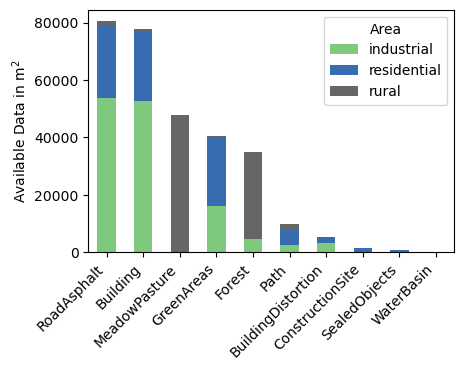

In [6]:
fig_filename = 'area_by_category.pdf'
image_size_cm = [12, 8]

fig, ax = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Aggregate the grouped data
data = gdf.groupby(['QA_categor', 'area'])['Shape_Area'].sum().unstack().fillna(0)

# Sort the data by the total size of each QA_categor
data['Total'] = data.sum(axis=1)
data = data.sort_values('Total', ascending=False).drop(columns='Total')

# Plot stacked bar chart
data.plot(kind='bar', stacked=True, ax=ax, colormap='Accent')

ax.set_xlabel(None)
ax.set_ylabel('Available Data in m$^2$')
ax.legend(title='Area')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig(figure_path / fig_filename, bbox_inches='tight')
plt.show()


## Visualizations of the Results

### Loss and accuracy

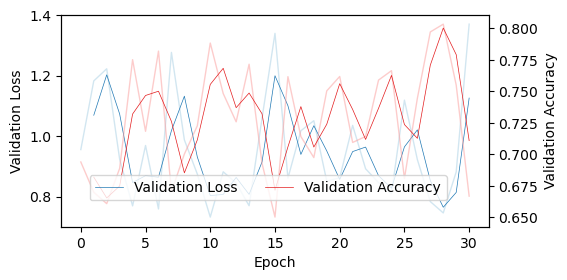

In [7]:
run = 'noaugment_complete'
metrics = pd.read_csv(log_path / run / 'metrics.csv')
image_size_cm = [14, 7]

validation_data = metrics[~metrics['valid_loss'].isnull()]

# Smooth the data
smoothed_val_loss = smooth_data(validation_data['valid_loss'], window_size=2)
smoothed_val_acc = smooth_data(validation_data['valid_acc'], window_size=2)

# Adjust the epoch range to match the length of the smoothed data
epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Plot unsmoothed valid_loss on the primary y-axis
ax1.plot(validation_data['epoch'], validation_data['valid_loss'], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_loss on the primary y-axis
ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=0.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.tick_params(axis='y')

# Create a secondary y-axis to plot valid_acc
ax2 = ax1.twinx()
# Plot unsmoothed valid_acc on the secondary y-axis
ax2.plot(validation_data['epoch'], validation_data['valid_acc'], color='#FB9A99', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_acc on the secondary y-axis
ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=0.5)
ax2.set_ylabel('Validation Accuracy')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=2)


### Visualizations of the Predictions

In [29]:
# load training data
ds_data = xr.open_zarr(data_path / 'combined.zarr').rio.write_crs(csr)
ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

areas = gpd.read_file(data_path / 'AOI_Labeled.shp')

# load predictions
run = 'noaugment_complete'
ds_predictions = xr.open_zarr(log_path / run / 'preds.zarr').rio.write_crs(csr).rename({"label_pred": "label"})

# saving coarsened data to save time in the future

areaLabels = [4, 8, 12]
target_path = log_path / run / 'processed_data'

if not os.path.exists(target_path):
    os.makedirs(target_path)
else:
    print('Directory already exists')

for areaLabel in areaLabels:

    clip_feature = areas[areas['DataLabel'] == areaLabel]
    clipped_data = ds_data.rio.clip(clip_feature.geometry, clip_feature.crs)
    clipped_predictions = ds_predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

    # Coarsen data
    data_label_coarsened = coarsen(clipped_data['label'], reduction='mode')
    data_rs_coarsened = coarsen(clipped_data['rs'])
    predictions_coarsened = coarsen(clipped_predictions['label'], reduction='mode')

    # Replace 255 with NaN and convert to int where appropriate
    data_label_coarsened = data_label_coarsened.where(data_label_coarsened != 255, np.nan).astype('float32')
    predictions_coarsened = predictions_coarsened.where(predictions_coarsened != 255, np.nan).astype('float32')

    # Save the coarsened data
    data_label_coarsened.to_netcdf(target_path / f'{areaLabel}_label.nc')
    data_rs_coarsened.to_netcdf(target_path / f'{areaLabel}_rs.nc')
    predictions_coarsened.to_netcdf(target_path / f'{areaLabel}_pred.nc')


C:\Users\kraft\AppData\Local\Temp\ipykernel_7708\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_7708\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_7708\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_

In [143]:
areaLabels = [4, 8, 12]
source_path = log_path / run / 'processed_data'

nc_files = [f for f in os.listdir(target_path) if f.endswith(".nc")]

nc_files

['4_label.nc',
 '4_rs.nc',
 '4_pred.nc',
 '8_label.nc',
 '8_rs.nc',
 '8_pred.nc',
 '12_label.nc',
 '12_rs.nc',
 '12_pred.nc']

In [47]:
source_path = log_path / run / 'processed_data' / nc_files[1]

file = xr.open_dataset(source_path)

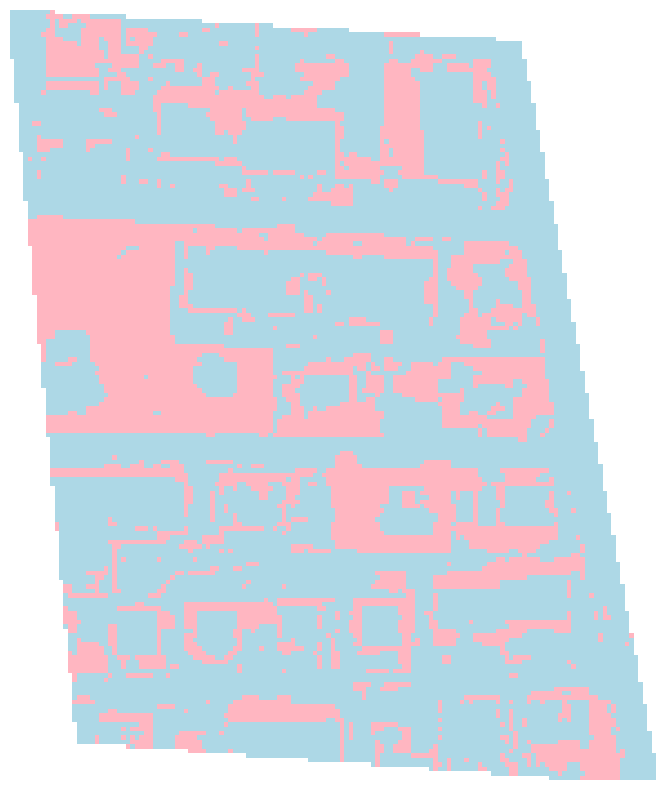

In [147]:
# plotting difference example

source_path = log_path / run / 'processed_data' / nc_files[3]
labels = xr.open_dataset(source_path)['label']

source_path = log_path / run / 'processed_data' / nc_files[5]
predictions = xr.open_dataset(source_path)['label']

difference = labels - predictions

difference_std = xr.where(np.isnan(difference), np.nan, xr.where(difference == 0, 0, 1))

diference_trans = difference_std.transpose('y', 'x')



# Plot the difference
plt.figure(figsize=(10, 10))
plt.imshow(diference_trans, cmap=dif_cmap, interpolation="nearest")
plt.axis('off')
plt.show()

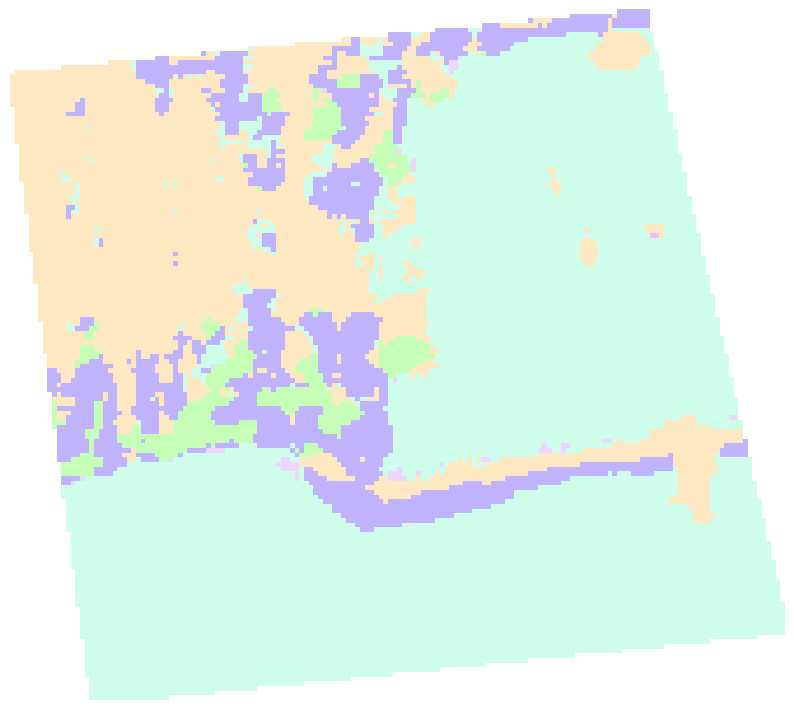

In [140]:
# plotting labels or predictions example

source_path = log_path / run / 'processed_data' / nc_files[2]

# Load the dataset
ds_data = xr.open_dataset(source_path)['label']

# Transpose the dataset
ds_data = ds_data.transpose('y', 'x')

# Plot the dataset
plt.figure(figsize=(10, 10))
plt.imshow(ds_data, cmap=class_cmap, norm=norm, interpolation="nearest")
plt.axis('off')
plt.show()

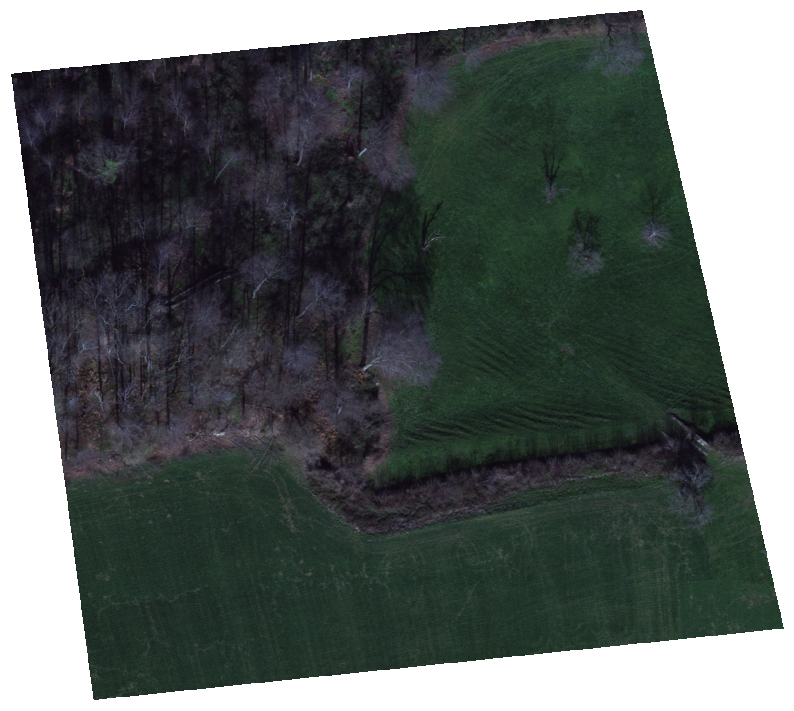

In [94]:
# Plotting RGB Example

def calculate_normalized_rgb(ds: xr.Dataset) -> np.ndarray:

    ds = ds['rs'].where(ds['rs'] != 0, np.nan)

    red_band = ds.sel(band=2)
    green_band = ds.sel(band=3)
    blue_band = ds.sel(band=4)

    # red_band = red_band.where(red_band != 0, np.nan)
    # green_band = green_band.where(green_band != 0, np.nan)
    # blue_band = blue_band.where(blue_band != 0, np.nan)

    def normalize(array):
        return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

    red_normalized = normalize(red_band)
    green_normalized = normalize(green_band)
    blue_normalized = normalize(blue_band)

    rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

    return rgb


ds_data = xr.open_zarr(data_path / 'combined.zarr').rio.write_crs(csr)
ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

areas = gpd.read_file(data_path / 'AOI_Labeled.shp')

clip_feature = areas[areas['DataLabel'] == 4]
clipped_data = ds_data.rio.clip(clip_feature.geometry, clip_feature.crs)

rgb = calculate_normalized_rgb(clipped_data)

plt.figure(figsize=(10, 10))
rgb_flipped = rgb.transpose((1, 0, 2))  # Swap x and y axes
plt.imshow(rgb_flipped)
plt.axis('off')
plt.show()

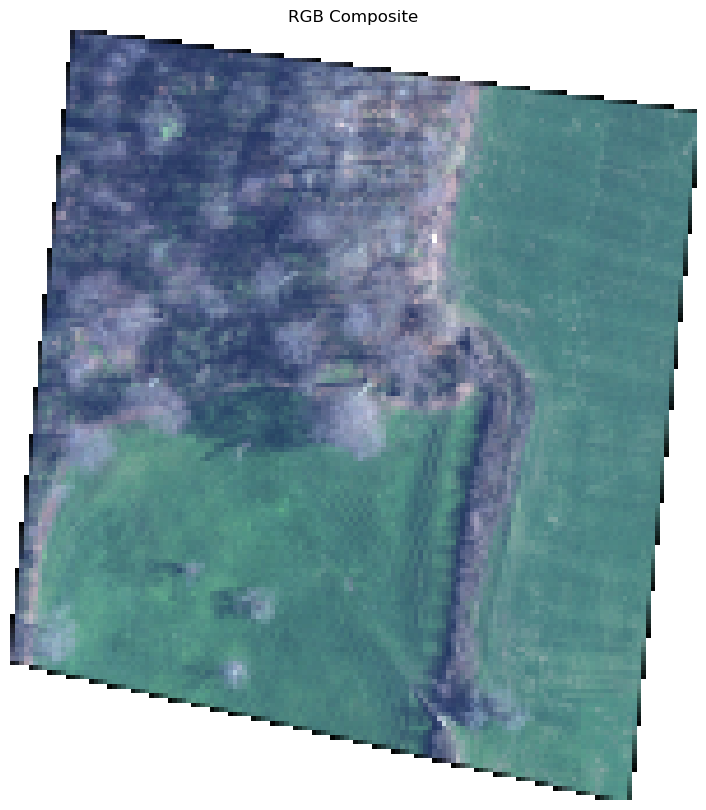

In [82]:
# Define the source path
source_path = log_path / run / 'processed_data' / nc_files[1]

# Load the dataset
ds_data = xr.open_dataset(source_path)['rs']

# Extract the RGB bands (assuming Band 2 = Red, Band 3 = Green, Band 4 = Blue)
red_band = ds_data.sel(band=2)
green_band = ds_data.sel(band=3)
blue_band = ds_data.sel(band=4)

red_band = red_band.where(red_band != 0, np.nan)
green_band = green_band.where(green_band != 0, np.nan)
blue_band = blue_band.where(blue_band != 0, np.nan)

# Define a normalization function
def normalize(array):
    """Normalize array values to the range [0, 1]."""
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

# Normalize the RGB bands
red_normalized = normalize(red_band)
green_normalized = normalize(green_band)
blue_normalized = normalize(blue_band)

# Combine the normalized bands into an RGB image
rgb = np.dstack((red_normalized, green_normalized, blue_normalized))
# rgb[rgb == 0] = np.nan

# Plot the RGB composite
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')
plt.title("RGB Composite")
plt.show()

In [80]:
print(red_band)

<xarray.DataArray 'rs' (x: 166, y: 148)> Size: 197kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(166, 148))
Coordinates:
  * x            (x) float64 1kB 2.618e+06 2.618e+06 ... 2.618e+06 2.618e+06
  * y            (y) float64 1kB 1.263e+06 1.263e+06 ... 1.263e+06 1.263e+06
    band         int32 4B 2
    spatial_ref  int32 4B ...


In [33]:
def plot_labels_and_predictions(training: xr.Dataset, predictions: xr.Dataset):
    # Image size in centimeters
    image_size_cm = [18, 10]

    # Create GridSpec layout
    fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], figure=fig)

    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    cax = fig.add_subplot(gs[0, 2])

    im1 = training.plot(vmin=0, vmax=9, ax=ax1, add_colorbar=False, cmap='Pastel1')
    im2 = predictions.plot(vmin=0, vmax=9, ax=ax2, add_colorbar=False, cmap='Pastel1')

    # colorbar
    cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
    cbar.set_label('Class')  # Label for the colorbar

    # Set axis titles
    ax1.set_title('Labels')
    ax2.set_title('Predictions')

    # Set proper axis labels for EPSG:2056
    ax1.set_xlabel('Eastings (m)')
    ax1.set_ylabel('Northings (m)')
    ax2.set_xlabel('Eastings (m)')
    ax2.set_ylabel(None)
    ax2.set_yticks([])

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return fig

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


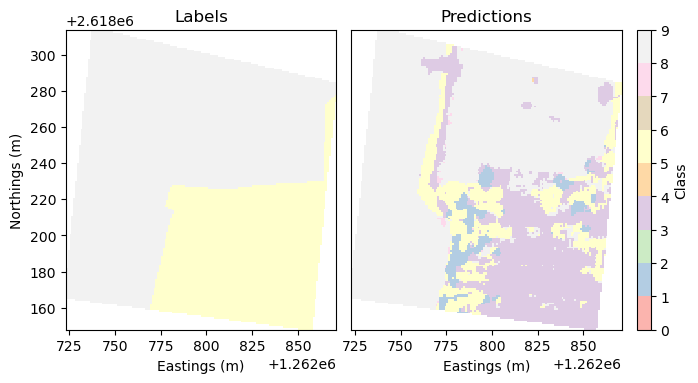

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


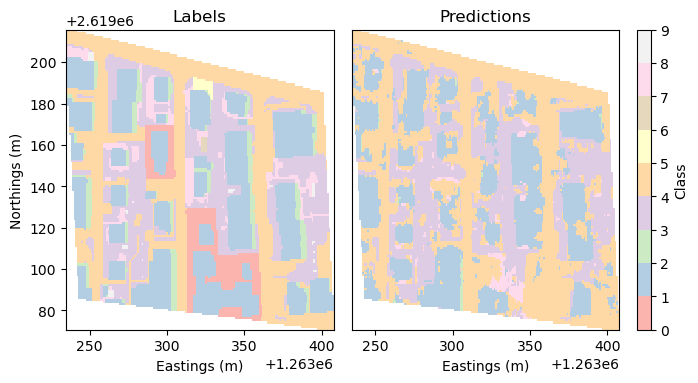

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


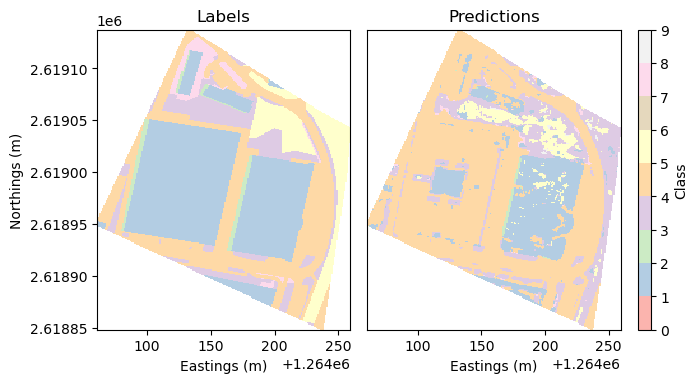

In [67]:
figures = []

trainLabels = [4, 8, 12]

for label in trainLabels:
    selectedDataLabel = label

    clip_feature = areas[areas['DataLabel'] == selectedDataLabel]
    clipped_training = ds_training.rio.clip(clip_feature.geometry, clip_feature.crs)
    clipped_predictions = ds_predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

    # Coarsen and plot with shared colorbar
    training_coarsened = coarsen(clipped_training['label'], reduction='mode')
    predictions_coarsened = coarsen(clipped_predictions['label'], reduction='mode')

    figure = plot_labels_and_predictions(training_coarsened, predictions_coarsened)
    figures.append(figure)


In [44]:
selectedDataLabel = 8

clip_feature = areas[areas['DataLabel'] == selectedDataLabel]
clipped_training = ds_training.rio.clip(clip_feature.geometry, clip_feature.crs)
clipped_predictions = ds_predictions.rio.clip(clip_feature.geometry, clip_feature.crs)


KeyboardInterrupt: 

In [60]:

# Coarsen and plot with shared colorbar
training_coarsened = coarsen(clipped_training['label'], reduction = 'mode')
predictions_coarsened = coarsen(clipped_predictions['label'], reduction = 'mode')

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


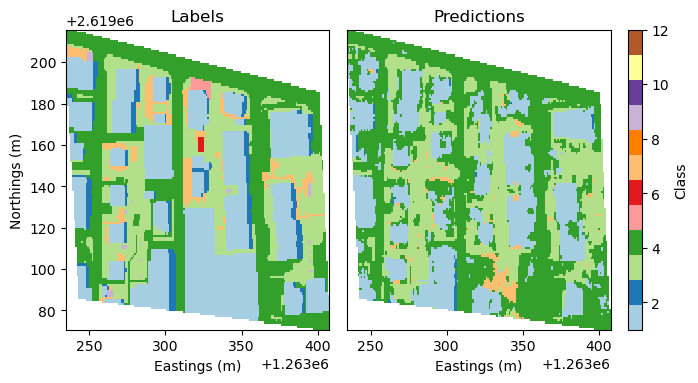

In [65]:
image_size_cm = [18, 10]

# Create GridSpec layout
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

im1 = training_coarsened.plot(vmin=1, vmax=12, ax=ax1, add_colorbar=False, cmap='Paired')
im2 = predictions_coarsened.plot(vmin=1, vmax=12, ax=ax2, add_colorbar=False, cmap='Paired')

# colorbar
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.set_label('Class')  # Label for the colorbar

# Set axis titles
ax1.set_title('Labels')
ax2.set_title('Predictions')

# Set proper axis labels for EPSG:2056
ax1.set_xlabel('Eastings (m)')
ax1.set_ylabel('Northings (m)')
ax2.set_xlabel('Eastings (m)')
ax2.set_ylabel(None)
ax2.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
# load training data
ds_data = xr.open_zarr(data_path / 'combined.zarr').rio.write_crs(csr)
ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

areas = gpd.read_file(data_path / 'AOI_Labeled.shp')

# load predictions
run = 'noaugment_complete'
ds_predictions = xr.open_zarr(log_path / run / 'preds.zarr').rio.write_crs(csr).rename({"label_pred": "label"})

ds_data_cors = coarsen(ds_data)
ds_pred_cors = coarsen(ds_predictions)

In [63]:
ds_pred_cors

<xarray.Dataset> Size: 398MB
Dimensions:        (x: 3181, y: 4165, cls: 10)
Coordinates:
  * cls            (cls) int64 80B 0 1 2 3 4 5 6 7 8 9
  * x              (x) float64 25kB 2.618e+06 2.618e+06 ... 2.621e+06 2.621e+06
  * y              (y) float64 33kB 1.266e+06 1.266e+06 ... 1.262e+06 1.262e+06
    spatial_ref    int64 8B 0
Data variables:
    label          (x, y) float16 26MB nan nan nan nan nan ... nan nan nan nan
    label_prob     (x, y, cls) float16 265MB nan nan nan nan ... nan nan nan nan
    training_mask  (x, y) float64 106MB 25.5 25.5 25.5 25.5 ... 0.0 0.0 0.0 0.0

In [41]:
def calculate_normalized_rgb(ds: xr.Dataset) -> np.ndarray:

    ds = ds['rs'].where(ds['rs'] != 0, np.nan)

    red_band = ds.sel(band=2)
    green_band = ds.sel(band=3)
    blue_band = ds.sel(band=4)

    # red_band = red_band.where(red_band != 0, np.nan)
    # green_band = green_band.where(green_band != 0, np.nan)
    # blue_band = blue_band.where(blue_band != 0, np.nan)

    def normalize(array):
        return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

    red_normalized = normalize(red_band)
    green_normalized = normalize(green_band)
    blue_normalized = normalize(blue_band)

    rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

    return rgb

In [94]:
class_info = {
    0: ["ConstructionSite", "#B5E4FF"],
    1: ["Building", "#C5FEB6"],
    2: ["BuildingDistortion", "#900C3F"],
    3: ["GreenAreas", "#FEE8C2"],
    4: ["RoadAsphalt", "#FAB6FE"],
    5: ["Forest", "#C0B2FD"],
    7: ["Path","#EED7FF"],
    6: ["WaterBasin", "#F4FFB3"],
    8: ["MeadowPasture", "#CEFEEB"],
    9: ["SealedObjects", "#FED7D1"],
}

# Generating Colormap and Norm
sorted_classes = sorted(class_info.keys())
colors = [class_info[key][1] for key in sorted_classes]

class_cmap = ListedColormap(colors)
bounds = list(sorted_classes) + [sorted_classes[-1] + 1]
norm = BoundaryNorm(bounds, class_cmap.N)

# Define the custom colormap for 0 (blue) and 1 (red)
diff_info = {
    10: ["Correct Prediction", "#7CB9E8"],
    11: ["Incorrect Prediction", "#FF6F91"],
}

dif_cmap = ListedColormap([diff_info[10][1], diff_info[11][1]])

legend_info = {**class_info, **diff_info}
legend_elements = [Patch(facecolor=legend_info[key][1], label=legend_info[key][0]) for key in sorted(legend_info.keys())]

In [88]:
legend_info = {**class_info, **diff_info}

legend_info

{0: ['ConstructionSite', '#B5E4FF'],
 1: ['Building', '#C5FEB6'],
 2: ['BuildingDistortion', '#900C3F'],
 3: ['GreenAreas', '#FEE8C2'],
 4: ['RoadAsphalt', '#FAB6FE'],
 5: ['Forest', '#C0B2FD'],
 7: ['Path', '#EED7FF'],
 6: ['WaterBasin', '#F4FFB3'],
 8: ['MeadowPasture', '#CEFEEB'],
 9: ['SealedObjects', '#FED7D1'],
 10: ['Correct', '#ADD8E6'],
 11: ['Incorrect', '#FFB6C1']}

In [67]:
areas = areas
dataset = ds_data_cors
predictions = ds_pred_cors
    
area_label = 12
    
clip_feature = areas[areas['DataLabel'] == area_label]

# clipped_dataset = dataset.rio.clip(clip_feature.geometry, clip_feature.crs)
clipped_predictions = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

# clipped_predictions = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)
clipped_predictions["label"]

<xarray.DataArray 'label' (x: 289, y: 200)> Size: 116kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(289, 200), dtype=float16)
Coordinates:
  * x            (x) float64 2kB 2.619e+06 2.619e+06 ... 2.619e+06 2.619e+06
  * y            (y) float64 2kB 1.264e+06 1.264e+06 ... 1.264e+06 1.264e+06
    spatial_ref  int64 8B 0

<xarray.Dataset> Size: 398MB
Dimensions:        (x: 3181, y: 4165, cls: 10)
Coordinates:
  * cls            (cls) int64 80B 0 1 2 3 4 5 6 7 8 9
  * x              (x) float64 25kB 2.618e+06 2.618e+06 ... 2.621e+06 2.621e+06
  * y              (y) float64 33kB 1.266e+06 1.266e+06 ... 1.262e+06 1.262e+06
    spatial_ref    int64 8B 0
Data variables:
    label          (x, y) float16 26MB nan nan nan nan nan ... nan nan nan nan
    label_prob     (x, y, cls) float16 265MB nan nan nan nan ... nan nan nan nan
    training_mask  (x, y) float64 106MB 25.5 25.5 25.5 25.5 ... 0.0 0.0 0.0 0.0


c:\Users\kraft\.conda\envs\sa2\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\kraft\.conda\envs\sa2\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\kraft\.conda\envs\sa2\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\kraft\.conda\envs\sa2\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\kraft\.conda\envs\sa2\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\kraft\.conda\envs\sa2\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\U

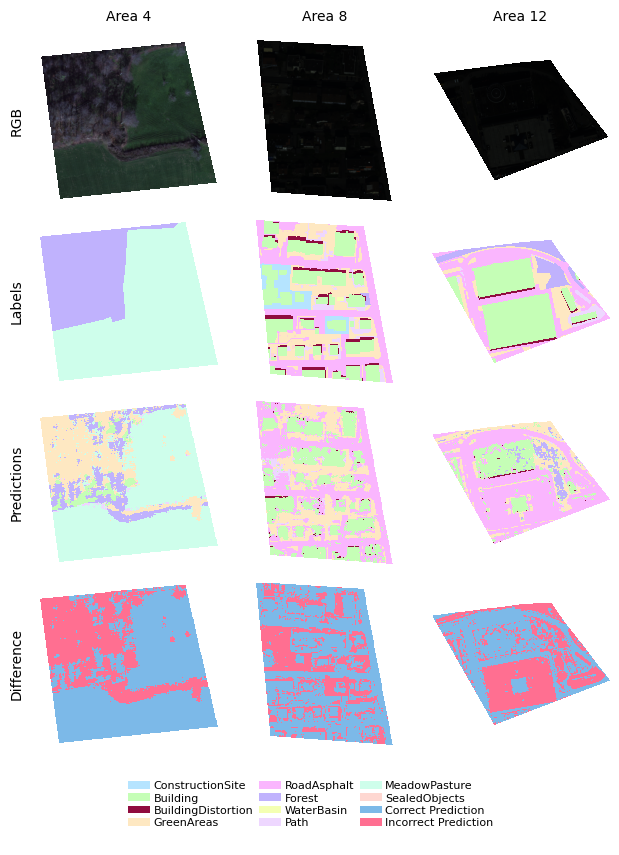

In [100]:
coarsen = False

path_to_dataset = data_path / 'combined.zarr'
path_to_predictions = log_path / run / 'preds.zarr'
path_to_areas = data_path / 'AOI_Labeled.shp'

# load training data
ds_data = xr.open_zarr(path_to_dataset).rio.write_crs(csr)
ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

areas = gpd.read_file(path_to_areas)

# load predictions
run = 'noaugment_complete'
ds_predictions = xr.open_zarr(path_to_predictions).rio.write_crs(csr).rename({"label_pred": "label"})

if coarsen: # Still for all data the same coarsen function - needs fixing
    dataset = coarsen(ds_data)
    predictions = coarsen(ds_predictions)
else:
    dataset = ds_data
    predictions = ds_predictions


image_size_cm = [16, 22]

# Create GridSpec layout with 5 rows and 4 columns
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(6, 4, width_ratios=[0.05, 1, 1, 1], height_ratios=[0.05, 1, 1, 1, 1, 0.5], figure=fig)

# Titles for the rows
titles_views = ["RGB", "Labels", "Predictions", "Difference"]
area_labels = [4, 8, 12]


# Add rotated titles to the first column (col 0)
for i, title in enumerate(titles_views):
    ax_title = fig.add_subplot(gs[i+1, 0])  # Create an axis in the (i, 0) position
    ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center', rotation=90)
    ax_title.axis('off')  # Turn off the axis

# # Add colorbar axis
legend_ax = fig.add_subplot(gs[5, 0:5])
legend_ax.axis('off')
legend_ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=False,
    ncol=3,  # Number of columns for the legend items
    bbox_to_anchor=(0.5, 0.5),  # Center the legend in the axis
    fontsize=8,  # Smaller font size
    columnspacing=0.5,  # Reduce space between columns
    handletextpad=0.3,  # Reduce space between handles and labels
    borderpad=0.2,  # Reduce padding inside the legend box
    labelspacing=0.2  # Reduce vertical space between labels
)

for i, area_label in enumerate(area_labels):
    # add a title for the row
    ax_title = fig.add_subplot(gs[0, i+1])
    ax_title.text(0.5, 0.5, f'Area {area_label}', fontsize=10, va='center', ha='center')
    ax_title.axis('off')

    # Clip the dataset and predictions to the current area
    clip_feature = areas[areas['DataLabel'] == area_label]
    clipped_dataset = dataset.rio.clip(clip_feature.geometry, clip_feature.crs)
    clipped_predictions = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

    # plottin RGB
    rs = clipped_dataset['rs']
    rgb = calculate_normalized_rgb(clipped_dataset).transpose((1, 0, 2))
    ax_rgb = fig.add_subplot(gs[1, i+1])
    ax_rgb.imshow(rgb)
    ax_rgb.axis('off')

    # Plotting labels
    labels = clipped_dataset['label'].transpose('y', 'x')
    ax_labels = fig.add_subplot(gs[2, i+1])
    ax_labels.imshow(labels, cmap=class_cmap, norm=norm, interpolation="nearest")
    ax_labels.axis('off')

    # Plotting predictions
    pred_labels = clipped_predictions['label'].transpose('y', 'x')
    ax_predictions = fig.add_subplot(gs[3, i+1])
    ax_predictions.imshow(pred_labels, cmap=class_cmap, norm=norm, interpolation="nearest")
    ax_predictions.axis('off')

    # Plotting difference
    difference = labels - pred_labels
    difference_std = xr.where(np.isnan(difference), np.nan, xr.where(difference == 0, 0, 1))
    ax_difference = fig.add_subplot(gs[4, i+1])
    ax_difference.imshow(difference_std, cmap=dif_cmap, interpolation="nearest")
    ax_difference.axis('off')

plt.subplots_adjust(
    hspace=0.1,  # Adjust vertical spacing
    wspace=0.1   # Adjust horizontal spacing
)

fig.tight_layout()
plt.show()
